# Fine_Tuning_Code_7조


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q monai

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 파이토치 Dataset으로 만들기

In [ ]:
import os
from PIL import Image
from torchvision import transforms
import random

class CustomDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        # random으로 추출
        # self.img_paths = sorted(random.sample(sorted([os.path.join(img_dir, img) for img in os.listdir(img_dir) if img.endswith(".png")]), 1000)) # 1000은 random 개수
        # self.label_paths = sorted([os.path.join(label_dir, label) for label in os.listdir(label_dir) if label.endswith(".png")])

        self.img_paths = sorted([os.path.join(img_dir, img) for img in os.listdir(img_dir) if img.endswith(".png")])
        self.label_paths = sorted([os.path.join(label_dir, label) for label in ([os.path.basename(path) for path in self.img_paths])])
        self.transform = transform

    def __len__(self):
        assert len(self.img_paths) == len(self.label_paths), "Not match"
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB')
        label = Image.open(self.label_paths[idx])

        if self.transform:
            img = self.transform(img)
            label = self.transform(label)

        return {'image': img, 'label': label}


In [ ]:
dataset_b = CustomDataset("/content/drive/MyDrive/Data_lost_image", "/content/drive/MyDrive/Data_lost_label"); dataset_b
# img_dir = "/content/drive/MyDrive/Data_lost_image"
# label_dir = "/content/drive/MyDrive/Data_lost_label"

In [ ]:
dataset_b[0]['image']
# len(dataset_b)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from scipy import ndimage

In [ ]:
np.array(dataset_b[1]["image"]).shape

(2160, 3840, 3)

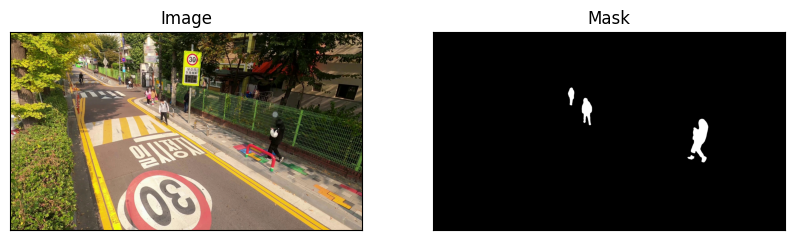

In [ ]:
# 이미지 확인

img_num = random.randint(0, len(dataset_b))
example_image = dataset_b[img_num]["image"]
example_mask = dataset_b[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title("Image")

axes[1].imshow(example_mask, cmap='gray')
axes[1].set_title("Mask")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

In [ ]:
# bounding box지정 함수

def get_bounding_box(ground_truth_map):
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
# 이미지 자르기 위한 값

left = (dataset_b[0]['image'].width - 2160)/2
top = (dataset_b[0]['image'].height - 2160)/2
right = (dataset_b[0]['image'].width +2160)/2
bottom = (dataset_b[0]['image'].height + 2160)/2

print(left, top, right, bottom)

In [ ]:
# SAM에 맞는 데이터셋으로 만들기

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    while True:
      item = self.dataset[idx]
      image = item["image"]
      image = image.crop((840, 0, 3000, 2160)) # 2160 * 3840 => 2160 * 2160
      label = item["label"]
      label = label.crop((840, 0, 3000, 2160)) # 2160 * 3840 => 2160 * 2160

      image = image.resize((1024, 1024))
      label = label.resize((1024, 1024))

      ground_truth_mask = np.array(label)

      if np.all(ground_truth_mask == 0):
        idx += 1
        if idx >= len(self.dataset):
          return None
        continue

      else:
        prompt = get_bounding_box(ground_truth_mask)
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

# Tuning Code

In [ ]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
import torch
import torchvision.transforms as transforms

In [ ]:
train_dataset = SAMDataset(dataset=dataset_b, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (1024, 1024)


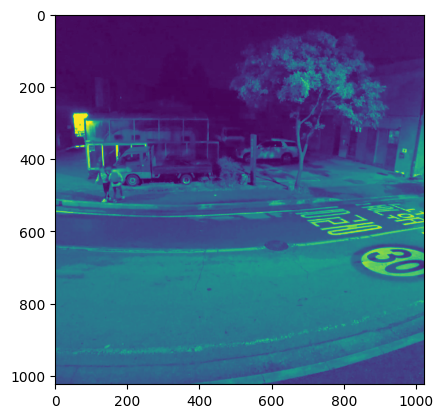

In [ ]:
plt.imshow(train_dataset[0]['pixel_values'][1].cpu().detach().numpy())

In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 1024, 1024])


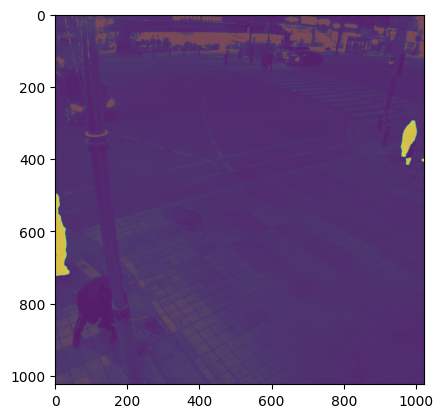

In [ ]:
plt.imshow(batch['pixel_values'][0][0], alpha = 0.7)
plt.imshow(batch['ground_truth_mask'][0], alpha = 0.7)

In [ ]:
# 모델 불러오기
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai

optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
from torch.nn.functional import threshold, normalize
import torchvision.transforms.functional as TF

# 에폭 지정
num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
mean_loss_train = []

for epoch in range(num_epochs):
    epoch_train_losses = []

    for batch in tqdm(dataloader):
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)


      predicted_masks = outputs.pred_masks.squeeze(1)
      predicted_masks = torch.nn.functional.interpolate(predicted_masks, size=(1024,1024))

      ground_truth_masks = (batch["ground_truth_mask"]/255).float().to(device) # 255 값을 1로 변경

      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()
      epoch_train_losses.append(loss.item())


    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_train_losses)}')

    mean_loss_train.append(mean(epoch_train_losses))

In [ ]:
plt.plot(mean_loss_train)

(-0.5, 1023.5, 1023.5, -0.5)

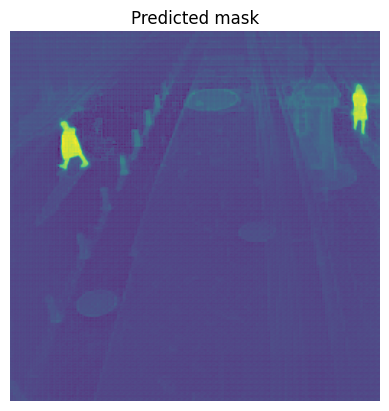

In [ ]:
# GT와 Predicted mask가 비슷하게 잡혔는지 확인.

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(ground_truth_masks[0].cpu().detach().numpy(), alpha = 0.7)
axes.imshow(predicted_masks[0][0].cpu().detach().numpy(), alpha = 0.7)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

In [ ]:
model.state_dict()

In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/MIA_TRACKING_7조/checkpoints/MIA_tracking_FineTune.pth")

# 모델 적용해보기

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor

In [ ]:
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

sam_model = SamModel(config=model_config)
sam_model.load_state_dict(torch.load("/content/drive/MyDrive/MIA_TRACKING_7조/checkpoints/MIA_tracking_FineTune.pth"))
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model.to(device)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


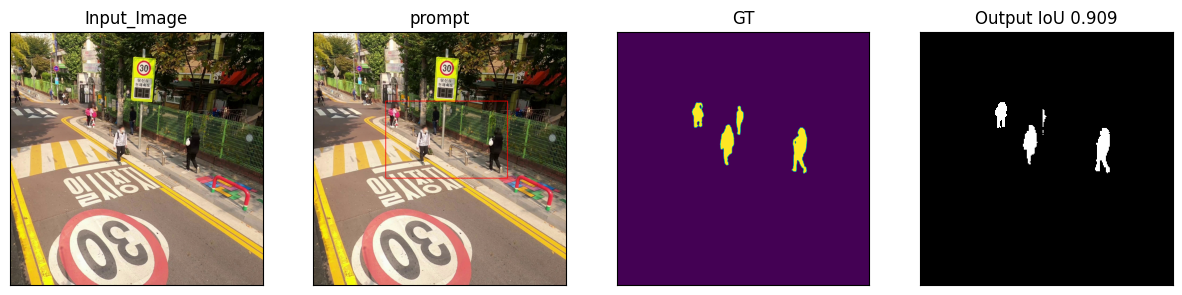

In [ ]:
# 원본, prompt, GT, Predicted Mask (IoU)

import json,os,math,copy,sys,random
import cv2
from PIL import Image,ImageOps

import numpy as np
import random
import torch
import matplotlib.pyplot as plt

idx = 10 # 확인하고자 하는 사진 idx 지정

image = dataset_b[idx]["image"]
image = image.crop((840, 0, 3000, 2160))
image = image.resize((1024, 1024))
image

ground_truth_mask = np.array(dataset_b[idx]["label"].crop((840, 0, 3000, 2160)).resize((1024,1024)))
prompt = get_bounding_box(ground_truth_mask)

inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)


test_image = np.array(image)

ground_truth_mask = np.array(dataset_b[idx]["label"].crop((840, 0, 3000, 2160)).resize((1024,1024)))
bbox_=prompt = get_bounding_box(ground_truth_mask)

inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

inputs = {k: v.to(device) for k, v in inputs.items()}

# 모델 사용
sam_model.eval()

with torch.no_grad():
    outputs = sam_model(**inputs, multimask_output=False)

medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


# 시각화

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

infer_masks = outputs["pred_masks"]
iou_scores = outputs["iou_scores"]
iou_scores_value = round(iou_scores.item(),3)

axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Input_Image")
axes[3].imshow(medsam_seg, cmap='gray')
axes[3].set_title(f"Output IoU {iou_scores_value}")
img_1 = copy.deepcopy(test_image)
cv2.rectangle(img_1, (bbox_[0], bbox_[1]), (bbox_[2], bbox_[3]), (255, 0, 0), 2)

axes[1].imshow(img_1, cmap='gray')
axes[1].set_title("prompt")

axes[2].imshow(ground_truth_mask)
axes[2].set_title(f"GT")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()